# Data Science with Neo4j 

This notebook walks you through connecting a Neo4j database on a Sandbox, data analysis on [citation dataset](https://www.aminer.org/citation), recommendations using graph algorithms, prediction of nodes linkage.

Workflow -

  * [Environment Setup](#Environment-Setup)
    * Import Modules
    * Start a Sandbox
    * Connect to Sandbox
  * [EDA](#EDA)
    * Query a database for its schema
    * Stat of node labels and relationship types 
    * Stat of papers and their citations 
  * [Recommendation System](#Recommendation-System)
    * Collaborative Filtering: Find potential collaborators for an author
    * PageRank
    * Personalized PageRank
  * [Predictions](#Predictions)
    * Train & Test Data
    * Feature Generation
      * Link Prediction Algorithm
      * Community Detection Algorithms
    * ML model using sklearn

## Environment Setup

Create a connection to your Neo4j Sandbox. 

<div align="left">
    <img src="https://github.com/neo4j-contrib/training-v2/blob/master/Courses/DataScience/notebooks/images/sandbox-citations.png?raw=1" alt="Citation Sandbox"/>
</div>

Update the cell below to use the IP Address, Bolt Port, and Password, as you did previously.

In [2]:
# Change the line of code below to use the IP Address, Bolt Port, and Password of your Sandbox.
# graph = Graph("bolt://<IP Address>:<Bolt Port>", auth=("neo4j", "<Password>")) 
 
graph = Graph("bolt://18.233.63.181:33466", auth=("neo4j", "nests-station-malfunctions"))

In [1]:
# Import Modules
from py2neo import Graph
import pandas as pd

import matplotlib 
import matplotlib.pyplot as plt

## EDA
### What's in the database?

Run the following query to check how many nodes our database contains:

In [3]:
graph.run("CALL db.schema()").data()

[{'nodes': [(_-3:Venue {constraints: ['CONSTRAINT ON ( venue:Venue ) ASSERT venue.name IS UNIQUE'], indexes: [], name: 'Venue'}),
   (_-1:Article {constraints: ['CONSTRAINT ON ( article:Article ) ASSERT article.index IS UNIQUE'], indexes: [], name: 'Article'}),
   (_-2:Author {constraints: ['CONSTRAINT ON ( author:Author ) ASSERT author.name IS UNIQUE'], indexes: [], name: 'Author'})],
  'relationships': [(Article)-[:VENUE {}]->(Venue),
   (Article)-[:AUTHOR {}]->(Author),
   (Article)-[:CITED {}]->(Article)]}]

If we run that query (CALL db.schema()) in  Neo4j Browser, you see the following visualisation:

<img src="https://github.com/neo4j-contrib/training-v2/blob/master/Courses/DataScience/notebooks/images/data-science-training.png?raw=1" alt="Graph Data Model"/>


__How many nodes do we have for each of these labels?__ 

In [4]:
result = {"label": [], "count": []}
for label in graph.run("CALL db.labels()").to_series():
    query = f"MATCH (:`{label}`) RETURN count(*) as count"
    count = graph.run(query).to_data_frame().iloc[0]['count']
    result["label"].append(label)
    result["count"].append(count)
nodes_df = pd.DataFrame(data=result)
nodes_df.sort_values("count")

,label,count
2,Venue,4
0,Article,51956
1,Author,80299


You can visualize the counts using matplotlib> Run the following code:

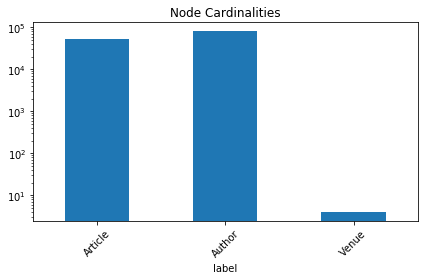

In [5]:
nodes_df.plot(kind='bar', x='label', y='count', legend=None, title="Node Cardinalities")
plt.yscale("log")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [6]:
# To find distinct properties of all the nodes
# MATCH (p) WITH p, keys(p) as pKeys UNWIND pKeys as Key RETURN distinct Key

__What types of relationships do we have in our graph?__ 

In [7]:
result = {"relType": [], "count": []}
for relationship_type in graph.run("CALL db.relationshipTypes()").to_series():
    query = f"MATCH ()-[:`{relationship_type}`]->() RETURN count(*) as count"
    count = graph.run(query).to_data_frame().iloc[0]['count']
    result["relType"].append(relationship_type)
    result["count"].append(count)
rels_df = pd.DataFrame(data=result)
rels_df.sort_values("count")

,relType,count
2,CITED,28706
0,VENUE,51956
1,AUTHOR,140575


You can visualize the counts using matplotlib. Run  the following code:

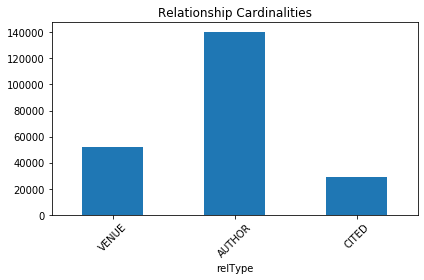

In [8]:
rels_df.plot(kind='bar', x='relType', y='count', legend=None, title="Relationship Cardinalities")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

__The following query finds 25 authors, articles, venues, and also shows the number of articles that article has cited, as well as the number of articles that it's been cited by in order.__

In [9]:
exploratory_query = """
MATCH (author:Author)<-[:AUTHOR]-(article:Article)-[:VENUE]->(venue)
RETURN article.title AS article, collect(author.name) AS author, venue.name AS venue, 
       size((article)-[:CITED]->()) AS citationsGiven, size((article)<-[:CITED]-()) AS citationsReceived
ORDER BY citationsReceived DESC
LIMIT 25
"""

graph.run(exploratory_query).to_data_frame().head()

,article,author,venue,citationsGiven,citationsReceived
0,Rough sets,"[Roman Słowiński, Jerzy W. Grzymala-Busse, Zdz...",Communications of The ACM,0,211
1,A method for obtaining digital signatures and ...,"[Adi Shamir, Leonard M. Adleman, Ronald L. Riv...",Communications of The ACM,1,125
2,"Pastry: Scalable, Decentralized Object Locatio...","[Antony I. T. Rowstron, Peter Druschel]",Lecture Notes in Computer Science,1,108
3,An axiomatic basis for computer programming,[C. A. R. Hoare],Communications of The ACM,0,93
4,"Time, clocks, and the ordering of events in a ...",[Leslie Lamport],Communications of The ACM,0,86


Let's look into the citation data more closely. Here is a query that returns the number of citations that each article has, and then creates a distribution of those counts using pandas `describe` function. Run this code:

In [10]:
query = """
MATCH (a:Article)
RETURN size((a)<-[:CITED]-()) AS citations
"""

citation_df = graph.run(query).to_data_frame()
citation_df.describe([.25, .5, .75, .9, .99])

,citations
count,51956.000000
mean,0.552506
std,2.417846
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
90%,1.000000
99%,8.000000
max,211.000000


Most articles are being cited very few times. 99% of articles have 8 citations or less. We do, however, have one article that's been cited more than 200 times. We'll use a log scale histogram to visualise the data. Run this code:

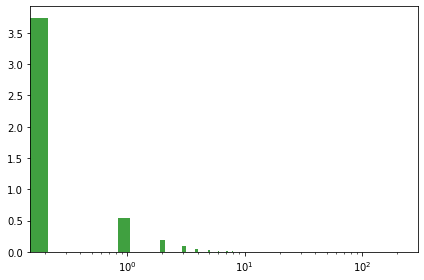

In [11]:
fig1, ax1 = plt.subplots()
ax1.hist(pd.Series(citation_df['citations'].dropna()), 1000, density=True, facecolor='g', alpha=0.75)
ax1.set_xscale("log")
plt.tight_layout()
plt.show()

## Recommendation System

Highlights:
* Find potential collaborators for an author.

###  Collaborative Filtering

__Since we're going to make collaborator suggestions find authors who have written the most articles.__

In [12]:
popular_authors_query = """
MATCH (author:Author)
RETURN author.name, size((author)<-[:AUTHOR]-()) AS articlesPublished
ORDER BY articlesPublished DESC
LIMIT 10
"""

graph.run(popular_authors_query).to_data_frame()

,author.name,articlesPublished
0,Peter G. Neumann,89
1,Peter J. Denning,80
2,Moshe Y. Vardi,72
3,Pamela Samuelson,71
4,Bart Preneel,65
5,Vinton G. Cerf,56
6,Barry W. Boehm,53
7,Mark Guzdial,49
8,Edwin R. Hancock,47
9,Josef Kittler,46


Pick one of these authors...

In [13]:
author_name = "Peter G. Neumann"

Retrieve the articles they've published and how many citations they've received:

In [14]:
author_articles_query = """
MATCH (:Author {name: $authorName})<-[:AUTHOR]-(article)
RETURN article.title AS article, article.year AS year, size((article:Article)<-[:CITED]-()) AS citations
ORDER BY citations DESC
LIMIT 20
"""

graph.run(author_articles_query,  {"authorName": author_name}).to_data_frame()

,article,year,citations
0,"The foresight saga, redux",2012,2
1,Security by obscurity,2003,2
2,Risks of automation: a cautionary total-system...,2016,1
3,Crypto policy perspectives,1994,1
4,Risks of National Identity Cards,2001,1
5,"Computers, ethics, and values",1991,1
6,Are dependable systems feasible,1993,1
7,Information system security redux,2003,1
8,The foresight saga,2006,1
9,Robust open-source software,1999,1


Find the author's collaborators:

In [15]:
collaborations_query = """
MATCH (:Author {name: $authorName})<-[:AUTHOR]-(article:Article)-[:AUTHOR]->(coauthor)
RETURN coauthor.name AS coauthor, count(*) AS collaborations
ORDER BY collaborations DESC
LIMIT 10
"""

graph.run(collaborations_query,  {"authorName": author_name}).to_data_frame()

,coauthor,collaborations
0,Lauren Weinstein,3
1,Whitfield Diffie,3
2,Susan Landau,3
3,Steven Michael Bellovin,2
4,Matt Blaze,2
5,Rebecca T. Mercuri,2
6,Alfred Z. Spector,1
7,Seymour E. Goodman,1
8,David Lorge Parnas,1
9,Douglas Miller,1


How would you suggest some future collaborators for this author? One way is by looking at the collaborators of their collaborators!

In [16]:
collaborations_query = """
MATCH (author:Author {name: $authorName})<-[:AUTHOR]-(article)-[:AUTHOR]->(coauthor),
      (coauthor)<-[:AUTHOR]-()-[:AUTHOR]->(coc)
WHERE not((coc)<-[:AUTHOR]-()-[:AUTHOR]->(author)) AND coc <> author      
RETURN coc.name AS coauthor, count(*) AS collaborations
ORDER BY collaborations DESC
LIMIT 10
"""

graph.run(collaborations_query,  {"authorName": author_name}).to_data_frame()

,coauthor,collaborations
0,John Ioannidis,10
1,Scott Bradner,9
2,Angelos D. Keromytis,8
3,John Kelsey,7
4,Virgil D. Gligor,5
5,David Wagner,4
6,Peter Wolcott,4
7,Ran Canetti,4
8,Gerald Jay Sussman,4
9,David K. Gifford,4


Each of these people have collaborated with someone that Peter has worked with before, so they might be able to do an introduction.

### PageRank
You will use the PageRank algorithm to make article recommendations to an author. Here is Neo4j documentation about [PageRank algorithm](https://neo4j.com/docs/graph-algorithms/current/algorithms/page-rank/).

PageRank is a __centrality algorithm__ that measures the transitive influence or connectivity of nodes. It can be computed by either iteratively distributing one node’s rank (originally based on degree) over its neighbors or by randomly traversing the graph and counting the frequency of hitting each node during these walks.

Run this PageRank code over the whole graph to find out the most influential article in terms of citations:

In [17]:
query = """
CALL algo.pageRank('Article', 'CITED')
"""
graph.run(query).data()

[{'nodes': 51956,
  'iterations': 20,
  'loadMillis': 114,
  'computeMillis': 84,
  'writeMillis': 456,
  'dampingFactor': 0.85,
  'write': True,
  'writeProperty': 'pagerank'}]

This query stores a 'pagerank' property on each node. Execute this code to view the most influential articles:

In [18]:
query = """
MATCH (a:Article)
RETURN a.title as article,
       a.pagerank as score
ORDER BY score DESC 
LIMIT 10
"""
graph.run(query).to_data_frame()

,article,score
0,A method for obtaining digital signatures and ...,93.943105
1,Secure communications over insecure channels,79.869224
2,Rough sets,25.609092
3,An axiomatic basis for computer programming,23.029374
4,"Pastry: Scalable, Decentralized Object Locatio...",21.469550
5,SCRIBE: The Design of a Large-Scale Event Noti...,19.486296
6,A field study of the software design process f...,19.028154
7,Productivity factors and programming environments,18.499351
8,Analyzing medium-scale software development,16.452748
9,A Calculus of Communicating Systems,15.430588


### Personalized PageRank

Personalized PageRank is a variant of PageRank that allows us to find influential nodes based on a set of source nodes.

For example, rather than finding the overall most influential articles, we could instead, find the most influential articles with respect to a given author.
Execute this code to use a personalized PageRank algorithm:

In [19]:
query = """
MATCH (a:Author {name: $author})<-[:AUTHOR]-(article)-[:CITED]->(other)
WITH collect(article) + collect(other) AS sourceNodes
CALL algo.pageRank.stream('Article', 'CITED', {sourceNodes: sourceNodes})
YIELD nodeId, score
RETURN algo.getNodeById(nodeId).title AS article, score
ORDER BY score DESC
LIMIT 10
"""

author_name = "Peter G. Neumann"
graph.run(query, {"author": author_name}).to_data_frame()

,article,score
0,A technique for software module specification ...,0.358528
1,A messy state of the union: taming the composi...,0.331688
2,Crypto policy perspectives,0.277500
3,Risks of automation: a cautionary total-system...,0.277500
4,The foresight saga,0.277500
5,Risks of e-voting,0.277500
6,Public interest and the NII,0.277500
7,Password security: a case history,0.277500
8,The challenges of partially automated driving,0.267938
9,Proof techniques for hierarchically structured...,0.248436


## Predictions

### Link Prediction Problem
[Abstract](https://www.cs.cornell.edu/home/kleinber/link-pred.pdf): Given a snapshot of a social network, can we infer which new interactions among its members are likely to occur in the near future? We formalize this question as the link prediction problem, and develop approaches to link prediction based on measures for analyzing the “proximity” of nodes in a network. Experiments on large co-authorship networks suggest that information about future interactions can be extracted from network topology alone...

<img src="LinkPrediction.png">

Here is Neo4j documentation about [Link Prediction Algorithm](https://neo4j.com/docs/graph-algorithms/current/labs-algorithms/linkprediction/index.html).

In [20]:
# Import modules
from collections import Counter
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, precision_score, accuracy_score

### Building a co-author graph
You will build an inferred graph of co-authors based on people collaborating on the same papers. You will store a property on the relationship indicating the year of their first collaboration.

In [21]:
query = """
CALL apoc.periodic.iterate(
  "MATCH (a1)<-[:AUTHOR]-(article)-[:AUTHOR]->(a2:Author)
   WITH a1, a2, article
   ORDER BY a1, article.year
   RETURN a1, a2, collect(article)[0].year AS year, count(*) AS collaborations",
  "MERGE (a1)-[coauthor:CO_AUTHOR {year: year}]-(a2)
   SET coauthor.collaborations = collaborations", 
  {batchSize: 100})
"""

graph.run(query)

### Train & Test Data

The tricky thing when working with graph data is that you cannot just randomly split the data, as this could lead to data leakage.

__Data leakage__ can occur when data outside of your training data is inadvertently used to create your model. This can easily happen when working with graphs because pairs of nodes in the training set may be connected to those in the test set. If the graph has a concept of time, things are easier as you can split the graph at a point in time. The training set will be from before the time, the test set after. This is still not a perfect solution and you must ensure that the general network structure in the training and test sub graphs is similar.

#### Positive/Negative Class:
Subsequently, pairs of nodes in our train and test datasets will have relationships between them. They will be the __positive examples__ in your machine learning model.

Because the citation graph contains times, you can create train and test graphs by splitting the data on a particular year. Next, you must determine what year that should be. Determine the distribution of the first year that co-authors collaborated:

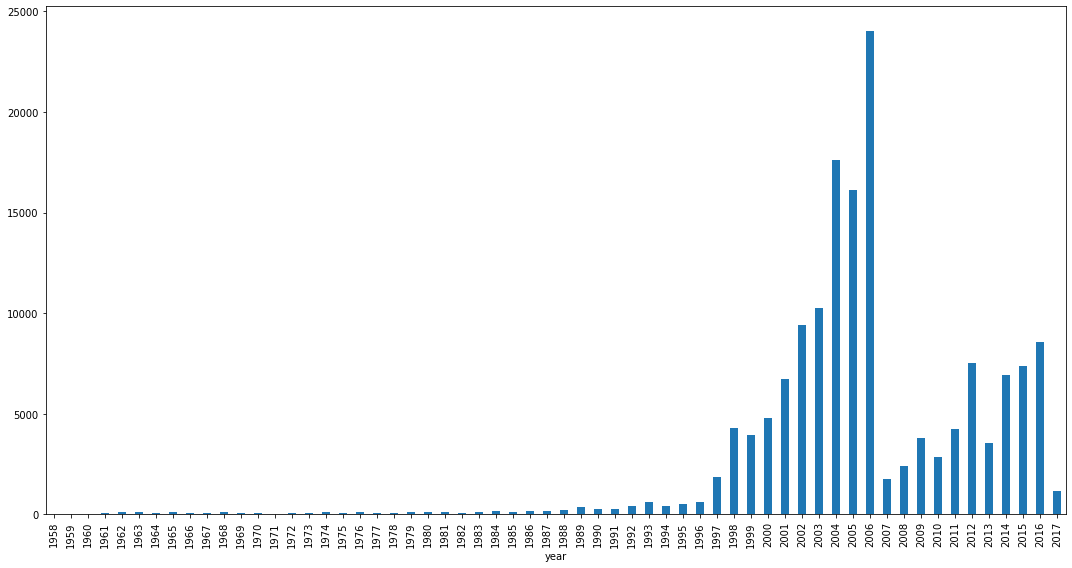

In [22]:
query = """
MATCH p=()-[r:CO_AUTHOR]->() 
WITH r.year AS year, count(*) AS count
ORDER BY year
RETURN toString(year) AS year, count
"""
by_year = graph.run(query).to_data_frame()

ax = by_year.plot(kind='bar', x='year', y='count', legend=None, figsize=(15,8))
plt.tight_layout()
plt.show()

It looks like 2006 would act as a good year for splitting the data. All co-authorships from 2005 and earlier as our train graph, and everything from 2006 onwards as the test graph.

Create explicit `CO_AUTHOR_EARLY` and `CO_AUTHOR_LATE` relationships in the graph based on that year. The following code will create these relationships:

In [23]:
query = """
MATCH (a)-[r:CO_AUTHOR]->(b) 
where r.year < 2006
MERGE (a)-[:CO_AUTHOR_EARLY {year: r.year}]-(b);
"""

graph.run(query).stats()

constraints_added: 0
constraints_removed: 0
contains_updates: True
indexes_added: 0
indexes_removed: 0
labels_added: 0
labels_removed: 0
nodes_created: 0
nodes_deleted: 0
properties_set: 81096
relationships_created: 81096
relationships_deleted: 0

In [24]:
query = """
MATCH (a)-[r:CO_AUTHOR]->(b) 
where r.year >= 2006
MERGE (a)-[:CO_AUTHOR_LATE {year: r.year}]-(b);
"""

graph.run(query).stats()

constraints_added: 0
constraints_removed: 0
contains_updates: True
indexes_added: 0
indexes_removed: 0
labels_added: 0
labels_removed: 0
nodes_created: 0
nodes_deleted: 0
properties_set: 74128
relationships_created: 74128
relationships_deleted: 0

Determine how many co-author relationship you have in each of these sub graphs:

In [25]:
query_early = """MATCH ()-[:CO_AUTHOR_EARLY]->() RETURN count(*) AS count"""
query_late = """MATCH ()-[:CO_AUTHOR_LATE]->() RETURN count(*) AS count"""

early_samples = graph.run(query_early).to_data_frame()['count'].tolist()[0]
late_samples = graph.run(query_late).to_data_frame()['count'].tolist()[0]
all_samples = early_samples + late_samples
print((early_samples, round(100*early_samples/all_samples,2)), (late_samples, round(100*late_samples/all_samples,2)))      
      

(81096, 52.24) (74128, 47.76)


This graph has a split of 52-48, which is a bit on the high side, but should be ok. Next, we create our negative examples.


#### Negative examples

The maximum number of negative examples is equal to:

```
# negative examples = (# nodes)² - (# relationships) - (# nodes)
```
If you were to use all of these negative examples in your training set, you would have a massive __class imbalance__. To reduce the number of negative examples, an approach described in several link prediction papers is to use pairs of nodes that are a __specific number of hops away from each other__. Further, downsampling of negative examples can be done.

In [26]:
def down_sample(df):
    copy = df.copy()
    zero = Counter(copy.label.values)[0] # for class 0
    un = Counter(copy.label.values)[1] # for class 1
    n = zero - un
    copy = copy.drop(copy[copy.label == 0].sample(n=n, random_state=1).index)
    return copy.sample(frac=1)

Now you are ready to build the train and test datasets based on the train and test sub graphs that you created. 

* The positive examples will be taken directly from the graph. 
* The negative examples will be found by looking for people who are 2 or 3 hops away from each other, excluding those that have already collaborated. You will then down sample those examples to equal the size of the positive examples. 

In [27]:
# training data
train_existing_links = graph.run("""
MATCH (author:Author)-[:CO_AUTHOR_EARLY]->(other:Author)
RETURN id(author) AS node1, id(other) AS node2, 1 AS label
""").to_data_frame()

train_missing_links = graph.run("""
MATCH (author:Author)
WHERE (author)-[:CO_AUTHOR_EARLY]-()
MATCH (author)-[:CO_AUTHOR_EARLY*2..3]-(other)
WHERE not((author)-[:CO_AUTHOR_EARLY]-(other))
RETURN id(author) AS node1, id(other) AS node2, 0 AS label
""").to_data_frame()
train_missing_links = train_missing_links.drop_duplicates()

In [28]:
training_df = train_missing_links.append(train_existing_links, ignore_index=True)
training_df['label'] = training_df['label'].astype('category')
training_df = down_sample(training_df)

In [29]:
training_df.head()

,node1,node2,label
889933,228245,165938,0
491858,91052,45254,0
1051859,78469,259254,1
728819,165958,145719,0
973849,2109,2116,1


Let's repeat the process for the test set:

In [30]:
test_existing_links = graph.run("""
MATCH (author:Author)-[:CO_AUTHOR_LATE]->(other:Author)
RETURN id(author) AS node1, id(other) AS node2, 1 AS label
""").to_data_frame()

test_missing_links = graph.run("""
MATCH (author:Author)
WHERE (author)-[:CO_AUTHOR_LATE]-()
MATCH (author)-[:CO_AUTHOR_LATE*2..3]-(other)
WHERE not((author)-[:CO_AUTHOR_LATE]-(other))
RETURN id(author) AS node1, id(other) AS node2, 0 AS label
""").to_data_frame()
test_missing_links = test_missing_links.drop_duplicates()

In [31]:
test_df = test_missing_links.append(test_existing_links, ignore_index=True)
test_df['label'] = test_df['label'].astype('category')
test_df = down_sample(test_df)

In [32]:
test_df.head()

,node1,node2,label
1309563,201110,201112,1
755829,174729,195662,0
72423,11495,1344,0
1040180,217706,209842,0
1316314,51764,222622,1


### Feature Generation (using Link Prediction algorithm)
Start by creating a simple model that tries to predict whether two authors will have a future collaboration based on features extracted from common authors, preferential attachment, and the total union of neighbors.

__Common Neighbours:__ This method is based on the assumption that two nodes with many common neighbours will be connected in the future. The more common neighbours the two users have, the higher the probability that a relationship between them will emerge.

__Preferential Attachment:__ The node with high degree is more likely to get new links.

__Total Neighbors__ computes the closeness of nodes, based on the number of unique neighbors that they have. It is based on the idea that the more connected a node is, the more likely it is to receive new links.

The following function computes each of these measures for pairs of nodes:

In [33]:
def apply_graphy_features(data, rel_type):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1,
           pair.node2 AS node2,
           algo.linkprediction.commonNeighbors(p1, p2, {relationshipQuery: $relType}) AS cn,
           algo.linkprediction.preferentialAttachment(p1, p2, {relationshipQuery: $relType}) AS pa,
           algo.linkprediction.totalNeighbors(p1, p2, {relationshipQuery: $relType}) AS tn
    """
    pairs = [{"node1": node1, "node2": node2}  for node1,node2 in data[["node1", "node2"]].values.tolist()]
    features = graph.run(query, {"pairs": pairs, "relType": rel_type}).to_data_frame()
    return pd.merge(data, features, on = ["node1", "node2"])

In [34]:
# training data
training_df = apply_graphy_features(training_df, "CO_AUTHOR_EARLY")

# test data
test_df = apply_graphy_features(test_df, "CO_AUTHOR_LATE")

In [35]:
training_df.head()

,node1,node2,label,cn,pa,tn
0,228245,165938,0,0.0,224.0,36.0
1,91052,45254,0,1.0,72.0,26.0
2,78469,259254,1,3.0,66.0,14.0
3,165958,145719,0,0.0,5.0,6.0
4,2109,2116,1,17.0,378.0,22.0


In [36]:
test_df.head()

,node1,node2,label,cn,pa,tn
0,201110,201112,1,5.0,36.0,7.0
1,174729,195662,0,2.0,20.0,7.0
2,11495,1344,0,0.0,70.0,17.0
3,217706,209842,0,0.0,3.0,4.0
4,51764,222622,1,0.0,14.0,15.0


#### ML model

In [37]:
classifier = RandomForestClassifier(n_estimators=30, max_depth=10, random_state=0)

In [38]:
# Let's start by just using one of the features - common neighbors
columns = ["cn"]

X = training_df[columns]
y = training_df["label"]
classifier.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=30,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [39]:
# model evaluation
def evaluate_model(predictions, actual):
    return pd.DataFrame({
        "Measure": ["Accuracy", "Precision", "Recall"],
        "Score": [accuracy_score(actual, predictions), 
                  precision_score(actual, predictions), 
                  recall_score(actual, predictions)]
    })

def feature_importance(columns, classifier):        
    display("Feature Importance")
    df = pd.DataFrame({
        "Feature": columns,
        "Importance": classifier.feature_importances_
    })
    df = df.sort_values("Importance", ascending=False)    
    ax = df.plot(kind='bar', x='Feature', y='Importance', legend=None)
    ax.xaxis.set_label_text("")
    plt.tight_layout()
    plt.show()

In [40]:
predictions = classifier.predict(test_df[columns])
y_test = test_df["label"]

display(evaluate_model(predictions, y_test))
#feature_importance(columns, classifier)

,Measure,Score
0,Accuracy,0.840060
1,Precision,0.952097
2,Recall,0.716153


The scores for accuracy and precision are adequate, but the recall is not very good. What happens if you include preferential attachment and total neighbors as well?

,Measure,Score
0,Accuracy,0.913535
1,Precision,0.922302
2,Recall,0.903154


'Feature Importance'

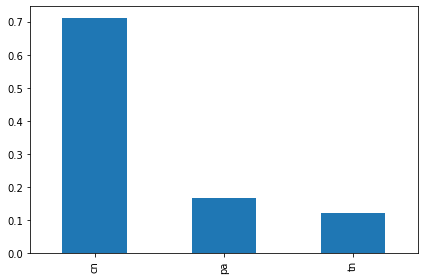

In [41]:
columns = ["cn", "pa", "tn"]

X = training_df[columns]
y = training_df["label"]
classifier.fit(X, y)

# model evaluation
predictions = classifier.predict(test_df[columns])
y_test = test_df["label"]

display(evaluate_model(predictions, y_test))
feature_importance(columns, classifier)

Common Neighbors is the dominant feature, but including the two other features has improved the accuracy and recall of the model.

Next, you will add some new features that are generated from graph algorithms.

### Community Detection

Community Detection algorithms evaluate how a group is clustered or partitioned. Nodes are considered more similar to nodes that fall in their community than to nodes in other communities. We consider triangle counting & clustering coefficient, Label Propagation and Louvain algorithms.

#### Triangle Counting & Clustering Coefficient

[Triangle counting](https://neo4j.com/docs/graph-algorithms/current/algorithms/triangle-counting-clustering-coefficient/) is a community detection graph algorithm that is used to determine the number of triangles passing through each node in the graph. Start by running the triangle count algorithm over the test and train sub-graphs. This algorithm will return the number of triangles that each node forms, as well as each node's clustering coefficient. In graph theory, a clustering coefficient is a measure of the degree to which nodes in a graph tend to cluster together. In the Graph Data Science library, this algorithm is in alpha stage and have syntax: gds.alpha.triangleCount.execution_mode(...)

More interested readers - adjacency matrix algebra for triangles count in a graph.

In [42]:
graph.run("""
CALL algo.triangleCount('Author', 'CO_AUTHOR_EARLY', { write:true,
writeProperty:'trianglesTrain', clusteringCoefficientProperty:'coefficientTrain'});
""").to_data_frame()

,loadMillis,computeMillis,writeMillis,postProcessingMillis,nodeCount,triangleCount,averageClusteringCoefficient,p1,p5,p10,p25,p50,p75,p90,p95,p99,p100,write,writeProperty,clusteringCoefficientProperty
0,573,169,15,250,80299,97205,0.375075,0,0,0,0,0,3,7,15,45,787,True,trianglesTrain,coefficientTrain


In [43]:
graph.run("""
CALL algo.triangleCount('Author', 'CO_AUTHOR_LATE', { write:true,
writeProperty:'trianglesTest', clusteringCoefficientProperty:'coefficientTest'});
""").to_data_frame()

,loadMillis,computeMillis,writeMillis,postProcessingMillis,nodeCount,triangleCount,averageClusteringCoefficient,p1,p5,p10,p25,p50,p75,p90,p95,p99,p100,write,writeProperty,clusteringCoefficientProperty
0,322,105,6,451,80299,95413,0.337097,0,0,0,0,0,3,6,14,55,647,True,trianglesTest,coefficientTest


The following function will add these features to the train and test DataFrames:

In [44]:
def apply_triangles_features(data, triangles_prop, coefficient_prop):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1, pair.node2 AS node2,
    apoc.coll.min([p1[$trianglesProp], p2[$trianglesProp]]) AS minTriangles,
    apoc.coll.max([p1[$trianglesProp], p2[$trianglesProp]]) AS maxTriangles,
    apoc.coll.min([p1[$coefficientProp], p2[$coefficientProp]]) AS minCoefficient,
    apoc.coll.max([p1[$coefficientProp], p2[$coefficientProp]]) AS maxCoefficient
    """    
    pairs = [{"node1": node1, "node2": node2}  for node1,node2 in data[["node1", "node2"]].values.tolist()]    
    params = {
    "pairs": pairs,
    "trianglesProp": triangles_prop,
    "coefficientProp": coefficient_prop
    }
    features = graph.run(query, params).to_data_frame()    
    return pd.merge(data, features, on = ["node1", "node2"])

Add the new features:

In [45]:
training_df = apply_triangles_features(training_df, "trianglesTrain", "coefficientTrain")
test_df = apply_triangles_features(test_df, "trianglesTest", "coefficientTest")

In [46]:
training_df.head()

,node1,node2,label,cn,pa,tn,minTriangles,maxTriangles,minCoefficient,maxCoefficient
0,228245,165938,0,0.0,224.0,36.0,8,378,0.285714,1.000000
1,91052,45254,0,1.0,72.0,26.0,3,276,1.000000,1.000000
2,78469,259254,1,3.0,66.0,14.0,7,16,0.290909,0.466667
3,165958,145719,0,0.0,5.0,6.0,0,10,0.000000,1.000000
4,2109,2116,1,17.0,378.0,22.0,113,119,0.566667,0.738562


In [47]:
test_df.head()

,node1,node2,label,cn,pa,tn,minTriangles,maxTriangles,minCoefficient,maxCoefficient
0,201110,201112,1,5.0,36.0,7.0,15,15,1.000000,1.000000
1,174729,195662,0,2.0,20.0,7.0,6,10,1.000000,1.000000
2,11495,1344,0,0.0,70.0,17.0,9,44,0.428571,0.977778
3,217706,209842,0,0.0,3.0,4.0,0,3,0.000000,1.000000
4,51764,222622,1,0.0,14.0,15.0,0,15,0.000000,0.164835


And now let's train and evaluate a model with these features:

,Measure,Score
0,Accuracy,0.957533
1,Precision,0.952757
2,Recall,0.962808


'Feature Importance'

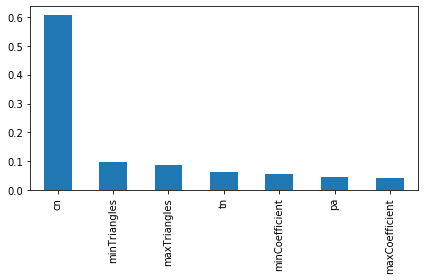

In [48]:
columns = [
    "cn", "pa", "tn", # graph features
    "minTriangles", "maxTriangles", "minCoefficient", "maxCoefficient" # triangle features  
]

X = training_df[columns]
y = training_df["label"]
classifier.fit(X, y)

predictions = classifier.predict(test_df[columns])
y_test = test_df["label"]

display(evaluate_model(predictions, y_test))
feature_importance(columns, classifier)

The coefficient features have not added much to our model, but the triangles are useful. Next you will see if Community Detection algorithms can help improve the model.

#### Label Propagation
The intuition behind [this algorithm](https://neo4j.com/docs/graph-algorithms/current/algorithms/label-propagation/) is that a single label can quickly become dominant in a densely connected group of nodes, but will have trouble crossing a sparsely connected region. Labels will get trapped inside a densely connected group of nodes, and those nodes that end up with the same label when the algorithms finish can be considered part of the same community.

In [49]:
graph.run("""
CALL algo.labelPropagation("Author", "CO_AUTHOR_EARLY", "BOTH",
{partitionProperty: "partitionTrain"});
""").to_data_frame()

,loadMillis,computeMillis,writeMillis,postProcessingMillis,nodes,communityCount,iterations,didConverge,p1,p5,...,p50,p75,p90,p95,p99,p100,weightProperty,write,partitionProperty,writeProperty
0,339,112,26,244,80299,47181,1,False,1,1,...,1,1,3,5,10,81,weight,True,partitionTrain,partitionTrain


In [50]:
graph.run("""
CALL algo.labelPropagation("Author", "CO_AUTHOR_LATE", "BOTH",
{partitionProperty: "partitionTest"});
""").to_data_frame()

,loadMillis,computeMillis,writeMillis,postProcessingMillis,nodes,communityCount,iterations,didConverge,p1,p5,...,p50,p75,p90,p95,p99,p100,weightProperty,write,partitionProperty,writeProperty
0,296,79,15,221,80299,51715,1,False,1,1,...,1,1,3,4,9,157,weight,True,partitionTest,partitionTest


#### Louvain 
[The Louvain algorithm](https://neo4j.com/docs/graph-algorithms/current/algorithms/louvain/) is a hierarchical clustering algorithm, that recursively merges communities into a single node and executes the modularity clustering on the condensed graphs. It maximizes a modularity score for each community, where the modularity quantifies the quality of an assignment of nodes to communities. This means evaluating how much more densely connected the nodes within a community are, compared to how connected they would be in a random network.

You will add a property to each node containing the community revealed on the first iteration of the algorithm:

In [51]:
graph.run("""
CALL algo.louvain.stream("Author", "CO_AUTHOR_EARLY", {includeIntermediateCommunities:true})
YIELD nodeId, community, communities
WITH algo.getNodeById(nodeId) AS node, communities[0] AS smallestCommunity
SET node.louvainTrain = smallestCommunity;
""").stats()

constraints_added: 0
constraints_removed: 0
contains_updates: True
indexes_added: 0
indexes_removed: 0
labels_added: 0
labels_removed: 0
nodes_created: 0
nodes_deleted: 0
properties_set: 80299
relationships_created: 0
relationships_deleted: 0

In [52]:
graph.run("""
CALL algo.louvain.stream("Author", "CO_AUTHOR_LATE", {includeIntermediateCommunities:true})
YIELD nodeId, community, communities
WITH algo.getNodeById(nodeId) AS node, communities[0] AS smallestCommunity
SET node.louvainTest = smallestCommunity;
""").stats()

constraints_added: 0
constraints_removed: 0
contains_updates: True
indexes_added: 0
indexes_removed: 0
labels_added: 0
labels_removed: 0
nodes_created: 0
nodes_deleted: 0
properties_set: 80299
relationships_created: 0
relationships_deleted: 0

The following function will add these features to the train and test DataFrames:

In [53]:
def apply_community_features(data, partition_prop, louvain_prop):
    query = """
    UNWIND $pairs AS pair
    MATCH (p1) WHERE id(p1) = pair.node1
    MATCH (p2) WHERE id(p2) = pair.node2
    RETURN pair.node1 AS node1,
    pair.node2 AS node2,
    algo.linkprediction.sameCommunity(p1, p2, $partitionProp) AS sp,    
    algo.linkprediction.sameCommunity(p1, p2, $louvainProp) AS sl
    """
    pairs = [{"node1": node1, "node2": node2}  for node1,node2 in data[["node1", "node2"]].values.tolist()]
    params = {
    "pairs": pairs,
    "partitionProp": partition_prop,
    "louvainProp": louvain_prop
    }
    features = graph.run(query, params).to_data_frame()
    return pd.merge(data, features, on = ["node1", "node2"])

In [54]:
training_df = apply_community_features(training_df, "partitionTrain", "louvainTrain")
test_df = apply_community_features(test_df, "partitionTest", "louvainTest")

In [55]:
training_df.head()

,node1,node2,label,cn,pa,tn,minTriangles,maxTriangles,minCoefficient,maxCoefficient,sp,sl
0,228245,165938,0,0.0,224.0,36.0,8,378,0.285714,1.000000,0.0,0.0
1,91052,45254,0,1.0,72.0,26.0,3,276,1.000000,1.000000,0.0,0.0
2,78469,259254,1,3.0,66.0,14.0,7,16,0.290909,0.466667,1.0,1.0
3,165958,145719,0,0.0,5.0,6.0,0,10,0.000000,1.000000,0.0,0.0
4,2109,2116,1,17.0,378.0,22.0,113,119,0.566667,0.738562,1.0,1.0


In [56]:
test_df.head()

,node1,node2,label,cn,pa,tn,minTriangles,maxTriangles,minCoefficient,maxCoefficient,sp,sl
0,201110,201112,1,5.0,36.0,7.0,15,15,1.000000,1.000000,1.0,1.0
1,174729,195662,0,2.0,20.0,7.0,6,10,1.000000,1.000000,1.0,1.0
2,11495,1344,0,0.0,70.0,17.0,9,44,0.428571,0.977778,0.0,0.0
3,217706,209842,0,0.0,3.0,4.0,0,3,0.000000,1.000000,0.0,0.0
4,51764,222622,1,0.0,14.0,15.0,0,15,0.000000,0.164835,1.0,1.0


,Measure,Score
0,Accuracy,0.968885
1,Precision,0.974615
2,Recall,0.962848


'Feature Importance'

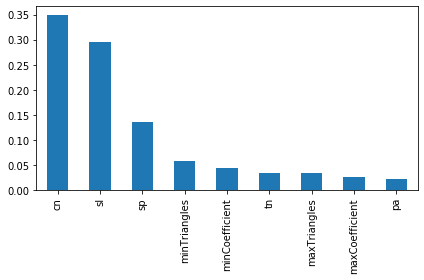

In [57]:
columns = [
    "cn", "pa", "tn", # graph features
    "minTriangles", "maxTriangles", "minCoefficient", "maxCoefficient", # triangle features  
    "sp", "sl" # community features
]

X = training_df[columns]
y = training_df["label"]
classifier.fit(X, y)

predictions = classifier.predict(test_df[columns])
y_test = test_df["label"]

display(evaluate_model(predictions, y_test))
feature_importance(columns, classifier)